INFO:postrprocess_visual.object_detection_visualizer:Using device: cuda


Using downloaded and verified file: ../VOC\VOCtrainval_06-Nov-2007.tar
Extracting ../VOC\VOCtrainval_06-Nov-2007.tar to ../VOC


C:\Users\K\PycharmProjects\object_detection\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


down_ratio = 4
loss_dict = {}


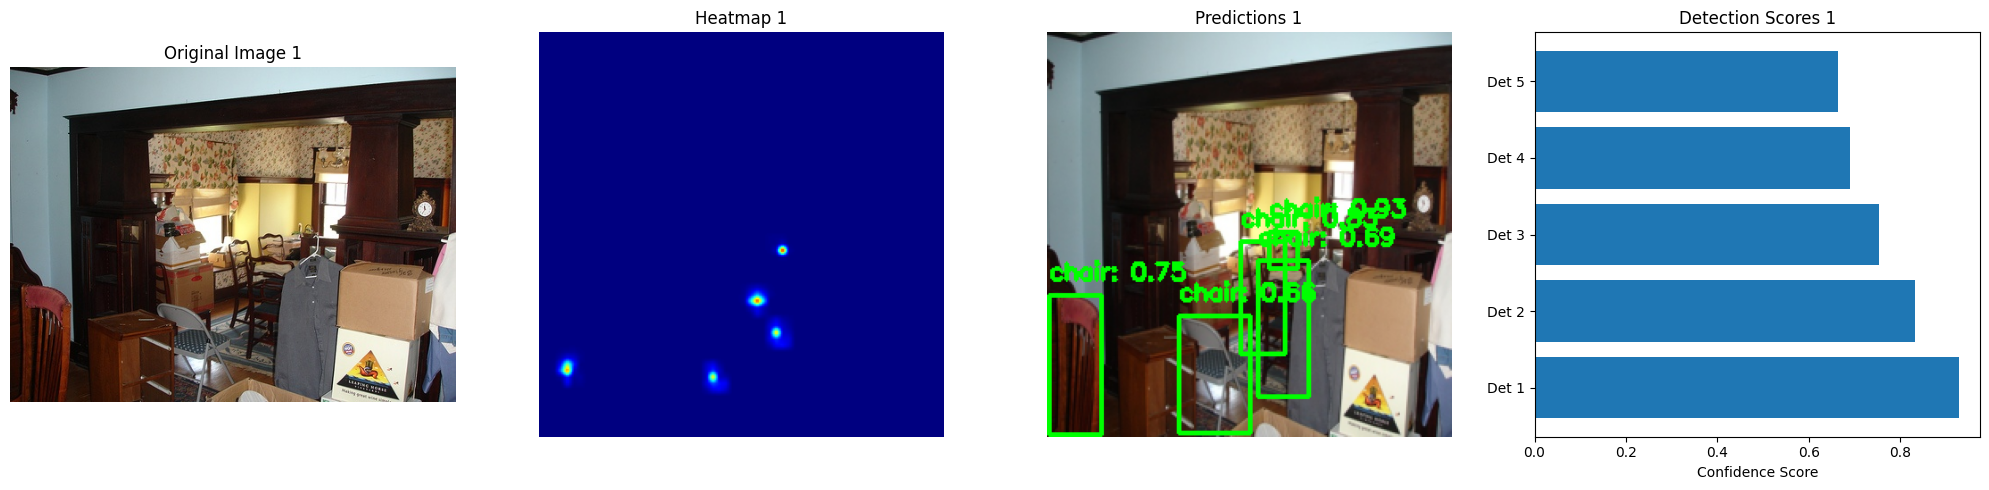

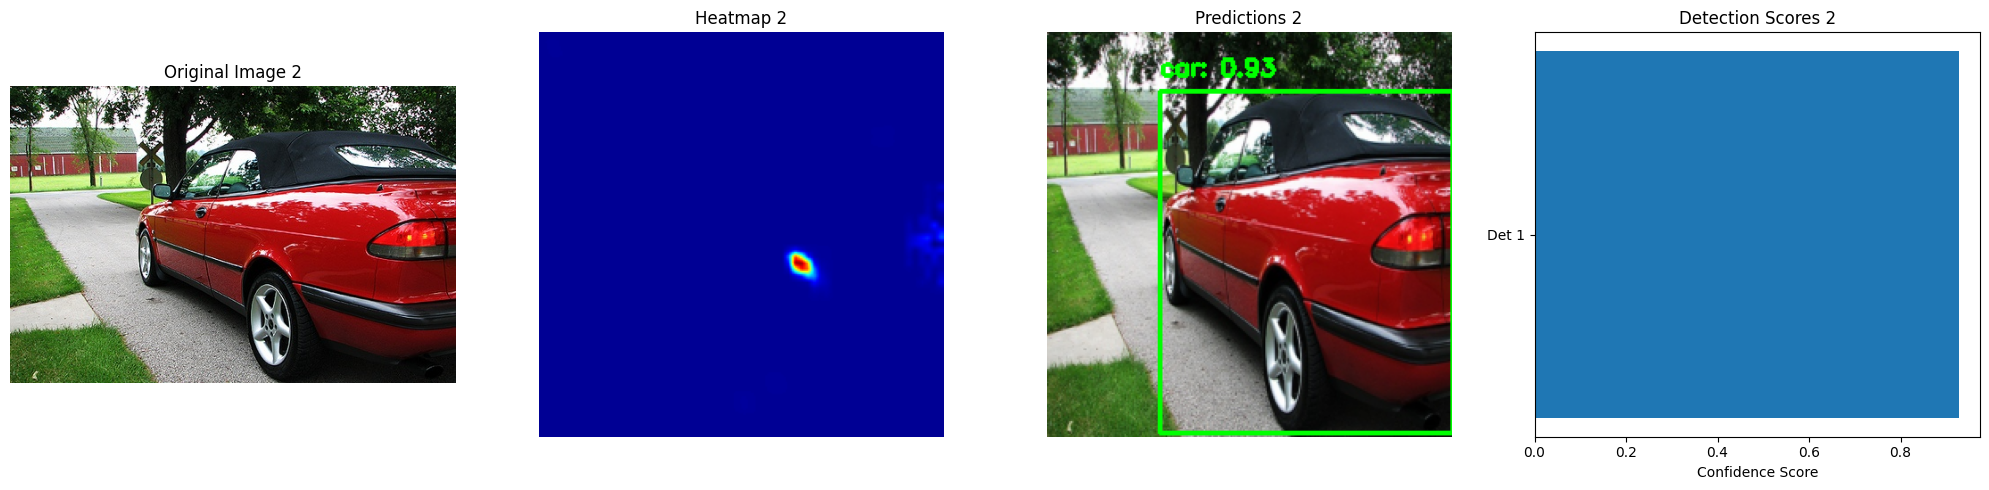

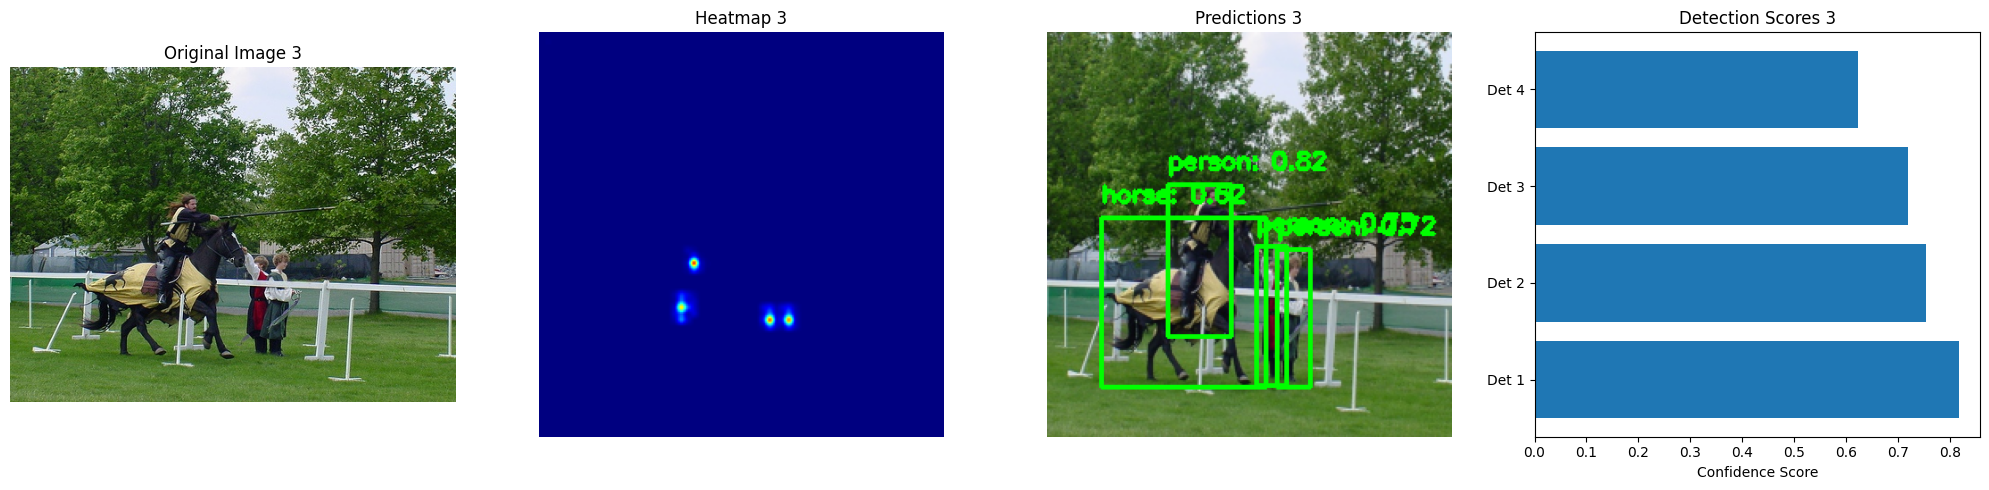

In [3]:
#visualizer_example.py
from postrprocess_visual.object_detection_visualizer import ObjectDetectionVisualizer

def main():
    # Create visualizer with default settings
    visualizer = ObjectDetectionVisualizer(
        input_height=256,
        input_width=256,
        confidence_threshold=0.3
    )

    # Visualize predictions
    visualizer.visualize_predictions(num_samples=3)

if __name__ == "__main__":
    main()